# 05. DheerajKumar97/Employee-Salary-Prediction----python--ML

## Prediction and XAI with Gradient Boosting Regression (T1) - train.csv

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import time
import lime, shap
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, get_scorer_names
df = pd.read_csv('05_train.csv')

C:\Users\Doğan Yiğit Yenigün\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# First 5 rows of the dataset
df.head()

User_ID Product_ID Gender   Age  Occupation City_Category  \
0  1000001  P00069042      F  0-17          10             A   
1  1000001  P00248942      F  0-17          10             A   
2  1000001  P00087842      F  0-17          10             A   
3  1000001  P00085442      F  0-17          10             A   
4  1000002  P00285442      M   55+          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                          2               0                   3   
1                          2               0                   1   
2                          2               0                  12   
3                          2               0                  12   
4                         4+               0                   8   

   Product_Category_2  Product_Category_3  Purchase  
0                 NaN                 NaN      8370  
1                 6.0                14.0     15200  
2                 NaN                 NaN      1422  
3                14.0                 NaN      1057  
4                 NaN                 NaN      7969

In [3]:
# All available columns, their counts and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


## Preprocessing

In [4]:
# Let's get the categorical columns by checking the data type
cat_var = [var for var in df.columns if df[var].dtypes == "object"]
cat_var = df[cat_var]
# Also check the unique values in those columns
print("Gender ->", cat_var['Gender'].unique())
print("Age ->", cat_var["Age"].unique())
print("City_Category ->", cat_var["City_Category"].unique())
print("Stay_In_Current_City_Years ->", cat_var['Stay_In_Current_City_Years'].unique())
cat_var.head(10)

Gender -> ['F' 'M']
Age -> ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']
City_Category -> ['A' 'C' 'B']
Stay_In_Current_City_Years -> ['2' '4+' '3' '1' '0']


Product_ID Gender    Age City_Category Stay_In_Current_City_Years
0  P00069042      F   0-17             A                          2
1  P00248942      F   0-17             A                          2
2  P00087842      F   0-17             A                          2
3  P00085442      F   0-17             A                          2
4  P00285442      M    55+             C                         4+
5  P00193542      M  26-35             A                          3
6  P00184942      M  46-50             B                          2
7  P00346142      M  46-50             B                          2
8   P0097242      M  46-50             B                          2
9  P00274942      M  26-35             A                          1

In [5]:
# Is there any NaN values in these columns?
cat_var.isna().sum()

Product_ID                    0
Gender                        0
Age                           0
City_Category                 0
Stay_In_Current_City_Years    0
dtype: int64

In [6]:
# Give these categorical age ranges some ordered values
def order_age(Age):
    if Age == "0-17":      return 1
    elif Age == "18-25":   return 2
    elif Age == "26-35":   return 3
    elif Age == "36-45":   return 4
    elif Age == "46-50":   return 5
    elif Age == "51-55":   return 6
    elif Age == "55+":     return 7
    else:    return 0
cat_var['Age'] = cat_var['Age'].apply(order_age)

In [7]:
# Give these categorical current city years being stayed some ordered values
def order_stay_in_current_city_years(Stay_In_Current_City_Years):
    if Stay_In_Current_City_Years == "0":      return 1
    elif Stay_In_Current_City_Years == "1":    return 2
    elif Stay_In_Current_City_Years == "2":    return 3
    elif Stay_In_Current_City_Years == "3":    return 4
    elif Stay_In_Current_City_Years == "4+":   return 5
cat_var['Stay_In_Current_City_Years'] = cat_var['Stay_In_Current_City_Years'].apply(order_stay_in_current_city_years)

In [8]:
# Latest status of categorical columns
cat_var

Product_ID Gender  Age City_Category  Stay_In_Current_City_Years
0       P00069042      F    1             A                           3
1       P00248942      F    1             A                           3
2       P00087842      F    1             A                           3
3       P00085442      F    1             A                           3
4       P00285442      M    7             C                           5
...           ...    ...  ...           ...                         ...
550063  P00372445      M    6             B                           2
550064  P00375436      F    3             C                           4
550065  P00375436      F    3             B                           5
550066  P00375436      F    7             C                           3
550067  P00371644      F    5             B                           5

[550068 rows x 5 columns]

In [9]:
# Let's get the numerical columns by checking the data type (by not being object)
num_var = [var for var in df.columns if df[var].dtypes !="object"]
num_var = df[num_var]
num_var

User_ID  Occupation  Marital_Status  Product_Category_1  \
0       1000001          10               0                   3   
1       1000001          10               0                   1   
2       1000001          10               0                  12   
3       1000001          10               0                  12   
4       1000002          16               0                   8   
...         ...         ...             ...                 ...   
550063  1006033          13               1                  20   
550064  1006035           1               0                  20   
550065  1006036          15               1                  20   
550066  1006038           1               0                  20   
550067  1006039           0               1                  20   

        Product_Category_2  Product_Category_3  Purchase  
0                      NaN                 NaN      8370  
1                      6.0                14.0     15200  
2                      NaN                 NaN      1422  
3                     14.0                 NaN      1057  
4                      NaN                 NaN      7969  
...                    ...                 ...       ...  
550063                 NaN                 NaN       368  
550064                 NaN                 NaN       371  
550065                 NaN                 NaN       137  
550066                 NaN                 NaN       365  
550067                 NaN                 NaN       490  

[550068 rows x 7 columns]

In [10]:
# However, these two columns will be dropped due to having null values, plus user ID has no meaning here.
num_var = num_var.drop(['Product_Category_2','Product_Category_3','User_ID'], axis=1)
num_var

Occupation  Marital_Status  Product_Category_1  Purchase
0               10               0                   3      8370
1               10               0                   1     15200
2               10               0                  12      1422
3               10               0                  12      1057
4               16               0                   8      7969
...            ...             ...                 ...       ...
550063          13               1                  20       368
550064           1               0                  20       371
550065          15               1                  20       137
550066           1               0                  20       365
550067           0               1                  20       490

[550068 rows x 4 columns]

## Prepare Train and Test Sets

In [11]:
# Create several dummy columns from categorical and numerical ones, then merge them with some other columns and purchase
dummy_gender = pd.get_dummies(cat_var['Gender'], prefix='gender')
dummy_age = pd.get_dummies(cat_var['Age'], prefix='age')
dummy_city = pd.get_dummies(cat_var['City_Category'], prefix='city')
dummy_city_years = pd.get_dummies(cat_var['Stay_In_Current_City_Years'], prefix='cityyears')
dummy_occupation = pd.get_dummies(num_var['Occupation'], prefix='occ')
dummy_prod_cat = pd.get_dummies(num_var['Product_Category_1'], prefix='prod_cat1')
df_cons = pd.concat([dummy_gender, dummy_age, dummy_city, dummy_city_years, dummy_occupation, dummy_prod_cat,
                    num_var['Marital_Status'], df['Purchase']], axis=1)
df_cons.head(8)

gender_F  gender_M  age_1  age_2  age_3  age_4  age_5  age_6  age_7  \
0         1         0      1      0      0      0      0      0      0   
1         1         0      1      0      0      0      0      0      0   
2         1         0      1      0      0      0      0      0      0   
3         1         0      1      0      0      0      0      0      0   
4         0         1      0      0      0      0      0      0      1   
5         0         1      0      0      1      0      0      0      0   
6         0         1      0      0      0      0      1      0      0   
7         0         1      0      0      0      0      1      0      0   

   city_A  ...  prod_cat1_13  prod_cat1_14  prod_cat1_15  prod_cat1_16  \
0       1  ...             0             0             0             0   
1       1  ...             0             0             0             0   
2       1  ...             0             0             0             0   
3       1  ...             0             0             0             0   
4       0  ...             0             0             0             0   
5       1  ...             0             0             0             0   
6       0  ...             0             0             0             0   
7       0  ...             0             0             0             0   

   prod_cat1_17  prod_cat1_18  prod_cat1_19  prod_cat1_20  Marital_Status  \
0             0             0             0             0               0   
1             0             0             0             0               0   
2             0             0             0             0               0   
3             0             0             0             0               0   
4             0             0             0             0               0   
5             0             0             0             0               0   
6             0             0             0             0               1   
7             0             0             0             0               1   

   Purchase  
0      8370  
1     15200  
2      1422  
3      1057  
4      7969  
5     15227  
6     19215  
7     15854  

[8 rows x 60 columns]

### Type 1: Use All Columns

In [12]:
# Use 80% of the dataset as training, and 20% as testing
X = df_cons.drop(columns='Purchase', axis=1)
Y = df_cons.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21)
print("TRAIN SIZE:", x_train.shape, " TEST SIZE:", x_test.shape)

TRAIN SIZE: (440054, 59)  TEST SIZE: (110014, 59)


## Predict with Gradient Boosting Regression

In [13]:
gradBoost = GradientBoostingRegressor()
gradBoost.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [14]:
# Fit the training data into the Gradient boosting regression model, then make predictions on the test data
s_time = time.time()
gradBoost.fit(x_train, y_train)
y_pred = gradBoost.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 60.875 seconds.


In [15]:
print("INIT:", gradBoost.init_)  # The estimator that provides the initial predictions
print("ESTIMATORS (FIRST 5):\n{}".format(gradBoost.estimators_[:5]))  # The collection of fitted sub-estimators
# The number of estimators as selected by early stopping (if 'n_iter_no_change' is specified).
# Otherwise, it is set to 'n_estimators'
print("# OF ESTIMATORS:", gradBoost.n_estimators_)
print("# OF FEATURES:", gradBoost.n_features_in_)  # Number of features seen during fit
print("MAX FEATURES:", gradBoost.max_features_)  # The inferred value of max_features
print("FEATURE IMPORTANCES:", gradBoost.feature_importances_)  # The impurity-based feature importances
# The i'th score 'train_score[i]' is the loss of the model at iteration i on the in-bag sample.
# If subsample == 1, this is the loss on the training data.
print("TRAIN SCORE:\n{}".format(gradBoost.train_score_))

INIT: DummyRegressor()
ESTIMATORS (FIRST 5):
[[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x2C930875740)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x2C930875740)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x2C930875740)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x2C930875740)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x2C930875740)]]
# OF ESTIMATORS: 100
# OF FEATURES: 59
MAX FEATURES: 59
FEATURE IMPORTANCES: [4.39466503e-05 4.84010610e-05 4.79861524e-05 1.52370341e-04
 8.64457614e-06 6.48437611e-05 7.94464504e-09 3.32182380e-04
 2.51285372e-05 1.85882307e-04 2.01692556e-04 3.9132916

In [16]:
# Compare the predicted values against the actual ones for the first 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

   7657.861234294663 |     5977
  13290.330940267124 |    19203
  13290.330940267124 |    15582
   7657.861234294663 |     5942
  13880.620294425009 |    20266
   6333.811143635616 |     8611
   3087.180493716707 |     2762
   7657.861234294663 |     3935
   9432.038681388447 |     5722
   7657.861234294663 |     6038
   6333.811143635616 |     5191
  13948.689648731744 |    15719
  13073.461955945295 |    15499
   6503.363353429553 |     8612
   7657.861234294663 |     7908
   6333.811143635616 |     8584
   7657.861234294663 |     3951
   6333.811143635616 |     8770
   7657.861234294663 |     7899
   18612.35749810959 |    23301


In [17]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)         
print("RMSE:", rmse)        
print("MAE:", mae)           
print("R2 SCORE:", r2) 
cross_val = cross_validate(gradBoost, X, Y, cv=5, return_train_score=True)
print("# CROSS VALIDATION #")
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())

MSE: 9233670.025087986
RMSE: 3038.695447899968
MAE: 2331.4894263410515
R2 SCORE: 0.633220706508604
# CROSS VALIDATION #
FITTING TIME: [59.33052325 60.25927162 59.22583461 54.89655876 54.55426359] -> 57.653290367126466
SCORING TIME: [0.27520895 0.26994205 0.23146772 0.24854255 0.23498249] -> 0.252028751373291
TRAIN SCORE: [0.63570591 0.63530718 0.63491907 0.63501344 0.62792549] -> 0.6337742169952985
TEST SCORE: [0.62304337 0.62439614 0.62601766 0.62539119 0.55276021] -> 0.6103217147945194


## Explain the Model with SHAP

In [18]:
shap.initjs()
shap_explainer = shap.Explainer(gradBoost, x_train)
shap_values = shap_explainer(x_test)
print(shap_values.shape)
print(shap_values)
print("\n EXPECTED VALUE:", shap_explainer.expected_value)

100%|===================| 109978/110014 [01:11<00:00]        

(110014, 59)
.values =
array([[ -0.72856369,   0.65316113,   0.91039581, ...,  59.04904083,
          0.        ,   0.16454453],
       [  0.        ,  -0.09011986,   0.91039581, ...,  59.04787323,
          0.        ,   0.16454453],
       [  0.        ,  -0.09011986,   0.91039581, ...,  59.04080917,
          0.        ,  -0.12340839],
       ...,
       [  0.        ,  -0.3154195 ,   0.91039581, ...,  58.84569702,
          0.        ,  -0.3907933 ],
       [ -0.60865807,   0.84448029, -10.72417427, ...,  61.04354645,
          0.        ,   0.16454453],
       [  0.        ,  -0.3154195 ,   0.91039581, ...,  58.84686462,
          0.        ,   0.55533785]])

.base_values =
array([9140.79705511, 9140.79705511, 9140.79705511, ..., 9140.79705511,
       9140.79705511, 9140.79705511])

.data =
array([[1, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ...,

### SUMMARY OF EXPLAINABILITY WITH SHAP ###


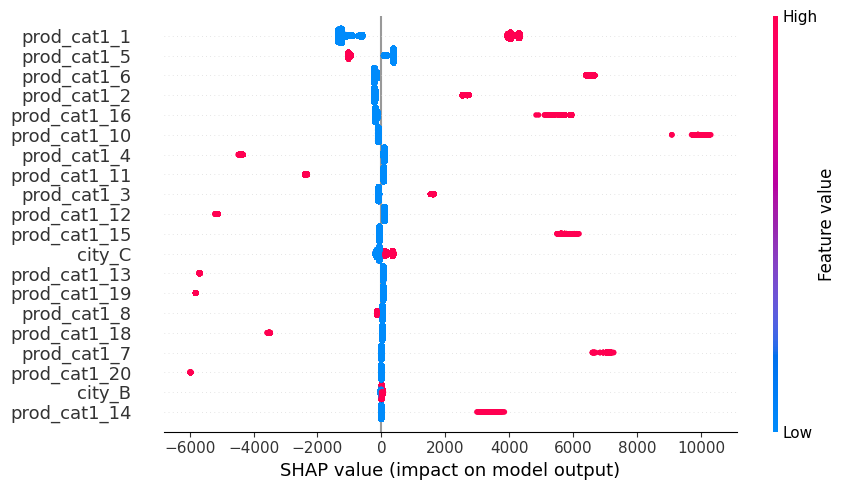

In [19]:
print("### SUMMARY OF EXPLAINABILITY WITH SHAP ###")
# shap.plots.beeswarm(shap_values)
shap.summary_plot(shap_values, x_test, plot_type='dot', plot_size=[9,5])

In [21]:
print("### VISUALIZATION OF FIRST 1000 PREDICTIONS ###")
shap.plots.force(shap_values[:1000])

### VISUALIZATION OF FIRST 1000 PREDICTIONS ###


### MEAN ABSOLUTE VALUES OF SHAP VALUES ###


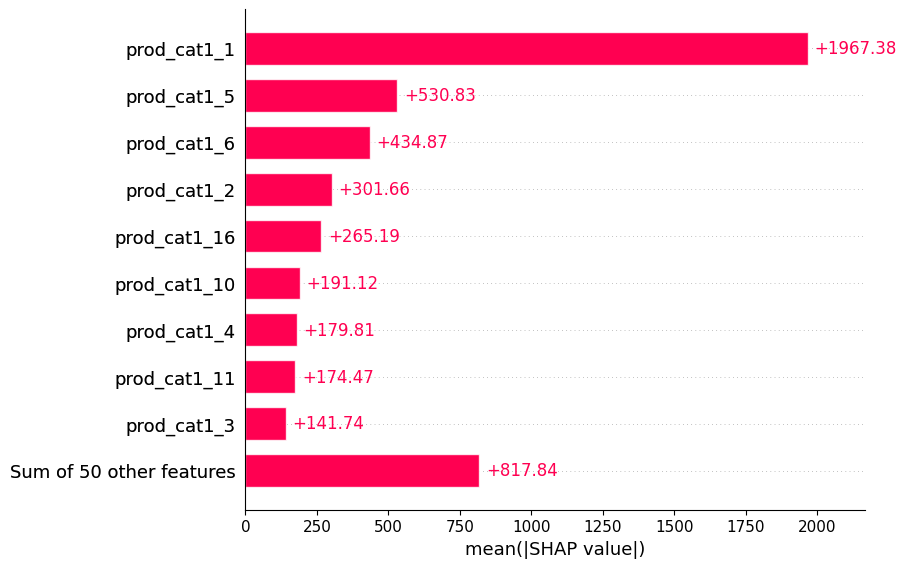

In [22]:
print("### MEAN ABSOLUTE VALUES OF SHAP VALUES ###")
shap.plots.bar(shap_values)

### EXPLAINING TEST ROW 25672 WITH SHAP ###


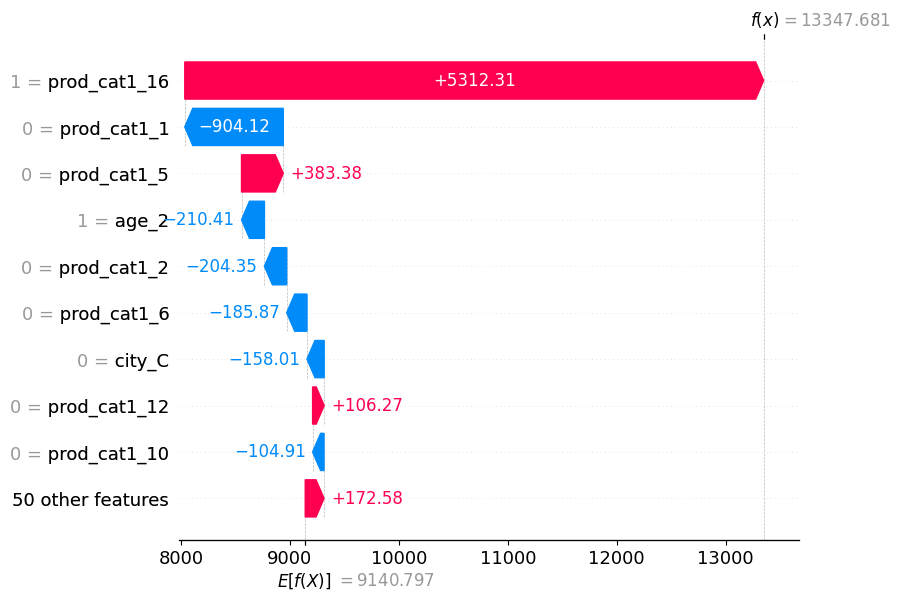

In [24]:
# i = 0
import random
i = random.randint(0, x_test.shape[0]-1)
print("### EXPLAINING TEST ROW {} WITH SHAP ###".format(i))
shap.plots.waterfall(shap_values[i])

In [25]:
print("### EXPLAINING TEST ROW {} WITH SHAP ###".format(i))
shap.plots.force(shap_values[i])

### EXPLAINING TEST ROW 25672 WITH SHAP ###


## Explain the Model with LIME

In [30]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, feature_names=df_cons.columns, 
                                                        class_names=['Purchase'], verbose=True, mode='regression')

In [32]:
i = random.randint(0, x_test.shape[0]-1)
print("### EXPLAINING TEST ROW {} WITH LIME ###".format(i))
exp = lime_explainer.explain_instance(x_test.iloc[i], gradBoost.predict, num_features=10)
exp.show_in_notebook(show_table=True)
exp.as_list()

### EXPLAINING TEST ROW 64912 WITH LIME ###
Intercept 18494.423347612632
Prediction_local [12729.06960073]
Right: 13290.330940267124


[('prod_cat1_10 <= 0.00', -8300.714899137893),
 ('prod_cat1_7 <= 0.00', -6947.89175898662),
 ('prod_cat1_6 <= 0.00', -5843.803752261445),
 ('prod_cat1_15 <= 0.00', -5731.14482877265),
 ('prod_cat1_20 <= 0.00', 5507.8811134931575),
 ('prod_cat1_13 <= 0.00', 5354.646218599077),
 ('prod_cat1_16 <= 0.00', -5265.761006910309),
 ('0.00 < prod_cat1_1 <= 1.00', 5235.333026681925),
 ('prod_cat1_19 <= 0.00', 5202.455327563963),
 ('prod_cat1_12 <= 0.00', 5023.646812847856)]